# Neural Networks

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [21]:
# Get features
samples = pd.read_csv("samples.csv", index_col=0)
microbes = pd.read_csv("microbes.csv", index_col=0)
metabolites = pd.read_csv("metabolites.csv", index_col=0)
combined_features = pd.concat([microbes, metabolites], axis=1)
# Label vector 
labels = samples.case

## Metabolites

In [28]:
# We'll use 80% for training, and 20% for testing
X_train, X_test, labels_train, labels_test = train_test_split(
    metabolites, labels, test_size=0.2, random_state=42)

In [97]:
nnet = MLPClassifier(solver='lbfgs', max_iter=300, learning_rate='invscaling',
                     hidden_layer_sizes=(10), activation='relu', random_state=42)
#scores = cross_val_score(rf, X_train, y_train, cv=5)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(nnet, X_train, labels_train, cv=5,
                         scoring=make_scorer(roc_auc_score))
print("AUC: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

AUC: 0.76 (+/- 0.12)


In [156]:
nnet = MLPClassifier(solver='lbfgs', alpha=.0001, max_iter=200, learning_rate='invscaling',
                     hidden_layer_sizes=(10), activation='relu', random_state=42)
#scores = cross_val_score(rf, X_train, y_train, cv=5)
#print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores = cross_val_score(nnet, X_train, labels_train, cv=5,
                         scoring=make_scorer(roc_auc_score))
print("AUC: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

AUC: 0.76 (+/- 0.12)


## Generate hyperparameter grid

In [157]:
hidden_layer_sizes = [(10, ), (20, )]
activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
alpha = [0.0001, .001, .01, .1]
batch_size = ['auto']
learning_rate = ['constant', 'invscaling', 'adaptive']
learning_rate_init = [0.001]
max_iter = [200, 300]
validation_fraction = [.2]
epsilon = [1e-08]
n_iter_no_change = [10]


# Create the random grid
random_grid = {'hidden_layer_sizes': hidden_layer_sizes,
               'activation': activation,
               'solver': solver,
               'alpha': alpha,
               'validation_fraction': validation_fraction,
               'learning_rate': learning_rate,
               'learning_rate_init': learning_rate_init,
               'max_iter': max_iter,
               'n_iter_no_change': n_iter_no_change,
               'random_state': [42]}

random_grid

{'hidden_layer_sizes': [(10,), (20,)],
 'activation': ['identity', 'logistic', 'tanh', 'relu'],
 'solver': ['lbfgs', 'sgd', 'adam'],
 'alpha': [0.0001, 0.001, 0.01, 0.1],
 'validation_fraction': [0.2],
 'learning_rate': ['constant', 'invscaling', 'adaptive'],
 'learning_rate_init': [0.001],
 'max_iter': [200, 300],
 'n_iter_no_change': [10],
 'random_state': [42]}

In [170]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
mlp = MLPClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
mlp_random = RandomizedSearchCV(estimator = mlp, param_distributions = random_grid,
                               n_iter = 100, cv = 5, verbose=2, random_state=42,
                               n_jobs = -1, scoring=make_scorer(roc_auc_score))

# Fit the random search model
mlp_random.fit(X_train, labels_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'hidden_layer_sizes': [(10,), (20,)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [0.0001, 0.001, 0.01, 0.1], 'validation_fraction': [0.2], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'learning_rate_init': [0.001], 'max_iter': [200, 300], 'n_iter_no_change': [10], 'random_state': [42]},
          pre_d

In [171]:
mlp_random.best_params_

{'validation_fraction': 0.2,
 'solver': 'lbfgs',
 'random_state': 42,
 'n_iter_no_change': 10,
 'max_iter': 300,
 'learning_rate_init': 0.001,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (10,),
 'alpha': 0.0001,
 'activation': 'relu'}

In [172]:
mlp_random.best_score_

0.7601877289377289

Default model

In [173]:
base_model = MLPClassifier(random_state = 42)
base_model.fit(X_train, labels_train)
pred = base_model.predict(X_test)

balanced_accuracy = balanced_accuracy_score(labels_test, pred)
accuracy = accuracy_score(labels_test, pred)
auc = roc_auc_score(y_true=labels_test, y_score=[j for i, j in base_model.predict_proba(X_test)])
print("Accuracy_score:", accuracy)
print("Balanced accuracy score:", balanced_accuracy)
print("AUC score:", auc)

Accuracy_score: 0.777777777778
Balanced accuracy score: 0.697368421053
AUC score: 0.684210526316


In [174]:
mlp_best = mlp_random.best_estimator_
mlp_best.fit(X_train, labels_train)
pred = rf_best.predict(X_test)

balanced_accuracy = balanced_accuracy_score(labels_test, pred)
accuracy = accuracy_score(labels_test, pred)
auc = roc_auc_score(y_true=labels_test, y_score=[j for i, j in mlp_best.predict_proba(X_test)])
print("Accuracy_score:", accuracy)
print("Balanced accuracy score:", balanced_accuracy)
print("AUC score:", auc)

Accuracy_score: 0.777777777778
Balanced accuracy score: 0.697368421053
AUC score: 0.75


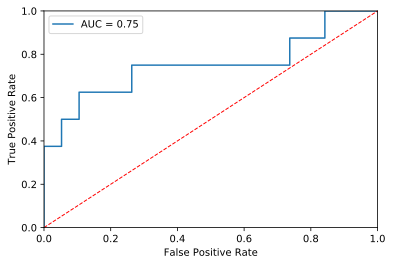

In [175]:
# Plot an ROC curve
fpr, tpr, _ = roc_curve(y_true=labels_test, y_score=[j for i, j in mlp_best.predict_proba(X_test)])
auc = roc_auc_score(y_true=labels_test, y_score=[j for i, j in mlp_best.predict_proba(X_test)])
plt.plot(fpr, tpr, label="AUC = {0:.2f}".format(auc))
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()